<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Виталий Радченко (YouScan) и Юрий Кашницкий (Mail.Ru Group).

Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №5
## <center> Случайный лес и логистическая регрессия в задачах кредитного скоринга и классификации отзывов к фильмам

#### Нашей главной задачей будет построение и настройка моделей для задач кредитного скоринга и анализа отзывов к фильмам. Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1s17pqYJ1kUez7F_c0qHDLYpucL5XMs9QWK4JgTfxk9E/edit).

Но для разминки решите первое задание.

**<font color='red'>Задание 1.</font>** В зале суда есть 7 присяжных, каждый из них по отдельности с вероятностью 80% может правильно определить, виновен подсудимый или нет. С какой вероятностью присяжные все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

**<font color='red'>Варианты ответа:</font>**
- 20.97%
- 80.00%
- 83.70%
- <b>96.66%</b>

Теперь перейдем непосредственно к машинному обучению.

#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

## Решаю, напомним формулу из лекции:
- $\large N $ — количество присяжных
- $\large p $ — вероятность правильного решения присяжного
- $\large \mu $ — вероятность правильного решения всего жюри
- $\large m $ — большинство членов жюри, $ m = (N+1)/2 $
- $\large C_N^i$ — число [сочетаний](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D1%87%D0%B5%D1%82%D0%B0%D0%BD%D0%B8%D0%B5) из $N$ по $i$
$$ \large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i} $$
Если $\large p > 0 $, то $\large \mu > p $
Если $\large N \rightarrow \infty $, то $\large \mu \rightarrow 1 $

In [6]:
import scipy.special
N = 7
p = 0.8
m = 4
np.sum([scipy.special.binom(N, i)*pow(p,i)*pow(1-p,N-i) for i in range(m,N+1)])

0.96665600000000007

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Напишем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы. 

In [3]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Считываем данные

In [4]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Рассмотрим типы считанных данных

In [10]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

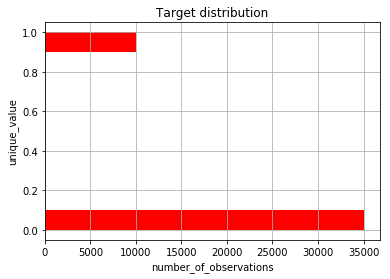

In [5]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Выберем названия всех признаков, кроме прогнозируемого

In [6]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [7]:
print (data.shape)
for c in independent_columns_names:
    print ('{:<40}{:>1}'.format(c, data[data[c].isnull() == True].shape[0]))

(45063, 8)
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
MonthlyIncome                           8643
NumberOfDependents                      1117


In [8]:
print (data['MonthlyIncome'].median())
print (data['NumberOfDependents'].median())

5166.0
0.0


Применяем функцию, заменяющую все значения NaN на медианное значение соответствующего столбца.

In [9]:
table = impute_nan_with_median(data)

Разделяем целевой признак и все остальные – получаем обучающую выборку. 

In [167]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

Выведем версии основных библиотек – результат `GridSearchCV`, например, может отличаться в разных версиях `sklearn` даже при фиксированном `random_state`.

In [17]:
#!pip install watermark
%load_ext watermark

In [18]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.6.3
IPython 6.1.0

numpy 1.13.3
scipy 0.19.1
pandas 0.20.3
matplotlib 2.1.0
sklearn 0.19.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 42 Stepping 7, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : fa395c7c003eb5aa4ae1b734d1ae297126422230


In [42]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.6.3
IPython 6.1.0

numpy 1.13.3
scipy 0.19.1
pandas 0.20.3
matplotlib 2.1.0
sklearn 0.19.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 42 Stepping 7, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : fa395c7c003eb5aa4ae1b734d1ae297126422230


# Бутстрэп

**<font color='red'>Задание 2.</font>** Сделайте интервальную оценку (на основе бутстрэпа) среднего дохода (MonthlyIncome) клиентов, просрочивших выплату кредита, и отдельно – для вовремя заплативших. Стройте 90% доверительный интервал. Найдите разницу между нижней границей полученного интервала для не просрочивших кредит и верхней границей – для просрочивших. 
То есть вас просят построить 90%-ые интервалы для дохода "хороших" клиентов $[good\_income\_lower, good\_income\_upper]$ и для "плохих" – $[bad\_income\_lower, bad\_income\_upper]$ и найти разницу $good\_income\_lower - bad\_income\_upper$.

Используйте пример из [статьи](https://habrahabr.ru/company/ods/blog/324402/). Поставьте `np.random.seed(17)`. Округлите ответ до целых.

**<font color='red'>Варианты ответа:</font>**
- 345
- 425
- 585
- <b>655</b>

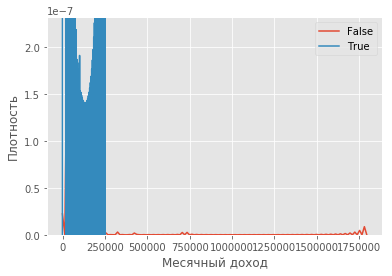

In [35]:
# Ваш код здесь
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
%matplotlib inline

telecom_data = pd.read_csv('../../data/telecom_churn.csv')

fig = sns.kdeplot(data[data['SeriousDlqin2yrs'] == False]['MonthlyIncome'], label = 'False')
fig = sns.kdeplot(data[data['SeriousDlqin2yrs'] == True]['MonthlyIncome'], label = 'True')        
fig.set(xlabel='Месячный доход', ylabel='Плотность')    
plt.show()

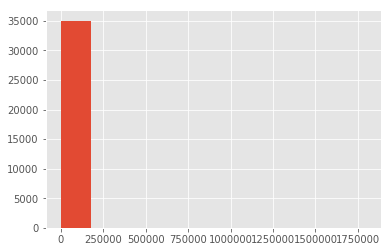

In [30]:
data[data['SeriousDlqin2yrs'] == False]['MonthlyIncome'].hist()

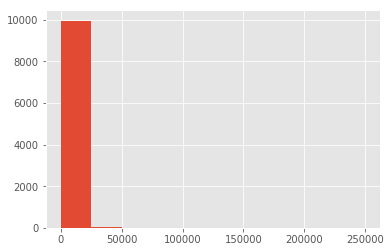

In [31]:
data[data['SeriousDlqin2yrs'] == True]['MonthlyIncome'].hist()

In [33]:
print (np.mean(data[data['SeriousDlqin2yrs'] == True]['MonthlyIncome']))
print (np.mean(data[data['SeriousDlqin2yrs'] == False]['MonthlyIncome']))

5553.448134849392
6392.165425122014


In [82]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
vfalse = data[data['SeriousDlqin2yrs'] == False]['MonthlyIncome'].values
vtrue= data[data['SeriousDlqin2yrs'] == True]['MonthlyIncome'].values

# ставим seed для воспроизводимости результатов
np.random.seed(17)

vfalse_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(vfalse, 1000)]
vtrue_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(vtrue, 1000)]

#  выводим интервальную оценку среднего
print("GOOD MonthlyIncome from false:  mean interval",  stat_intervals(vfalse_mean_scores, 0.10))
print("BAD   MonthlyIncome from true:  mean interval",  stat_intervals(vtrue_mean_scores, 0.10))
print(stat_intervals(vfalse_mean_scores, 0.10)[0] - stat_intervals(vtrue_mean_scores, 0.10)[1])

GOOD MonthlyIncome from false:  mean interval [ 6295.93237577  6505.35467934]
BAD   MonthlyIncome from true:  mean interval [ 5471.64826451  5643.93562737]
651.996748405


In [94]:
get_bootstrap_samples(vfalse, 2)

array([[  5674.,   4333.,   5300., ...,   2000.,   5166.,  19866.],
       [  5471.,  10000.,   3375., ...,   2484.,   5000.,  10500.]])

# Дерево решений, подбор гиперпараметров

Одной из основных метрик качества модели является площадь под ROC-кривой. Значения ROC-AUC лежат от 0 до 1. Чем ближе значение ROC-AUC к 1, тем качественнее происходит классификация моделью.

Найдите с помощью `GridSearchCV` гиперпараметры `DecisionTreeClassifier`, максимизирующие площадь под ROC-кривой. 

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Используем модуль `DecisionTreeClassifier` для построения дерева решений. Из-за несбалансированности классов  в целевом признаке добавляем параметр балансировки. Используем также параметр `random_state=17` для воспроизводимости результатов.

In [12]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

The ["balanced"](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as 
<br>
`n_samples / (n_classes * np.bincount(y))`

In [47]:
np.bincount(data['SeriousDlqin2yrs'])

array([35037, 10026], dtype=int64)

Перебирать будем вот такие значения гиперпараметров:

In [13]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Зафиксируем кросс-валидацию: стратифицированная, 5 разбиений с перемешиванием, не забываем про `random_state`.

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

**<font color='red'>Задание 3.</font>**
Сделайте GridSearch с метрикой ROC AUC по гиперпараметрам из словаря `tree_params`. Какое максимальное значение ROC AUC получилось (округлите до 2 знаков после разделителя)? Назовем кросс-валидацию устойчивой, если стандартное отклонение метрики качества на кросс-валидации меньше 1%. Получилась ли кросс-валидация устойчивой при оптимальных сочетаниях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC на кросс-валидации)?

**<font color='red'>Варианты ответа:</font>**
- 0.82, нет
- 0.84, нет
- <b>0.82, да</b>
- 0.84, да

In [15]:
# Ваш код здесь
from sklearn.model_selection import train_test_split, GridSearchCV

In [16]:
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))

[    0     2     3 ..., 45059 45060 45062] [    1     4    14 ..., 45043 45045 45061]
[    0     1     2 ..., 45060 45061 45062] [    6     9    15 ..., 45032 45035 45056]
[    1     2     3 ..., 45060 45061 45062] [    0    10    13 ..., 45054 45055 45058]
[    0     1     2 ..., 45058 45059 45061] [   12    24    26 ..., 45057 45060 45062]
[    0     1     4 ..., 45060 45061 45062] [    2     3     5 ..., 45048 45049 45059]


In [17]:
tree_grid = GridSearchCV(dt, tree_params, cv=skf, n_jobs=-1, verbose=True, scoring='roc_auc')

In [18]:
tree_grid.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [19]:
tree_grid.cv_results_['mean_test_score']

array([ 0.81089154,  0.8043939 ,  0.81111502,  0.81487177,  0.81574356,
        0.81615275,  0.8146449 ,  0.81903996,  0.81754694,  0.81685585,
        0.82030235,  0.81903131,  0.81448767,  0.81661305,  0.8148858 ,
        0.8163828 ,  0.80887829,  0.81197468,  0.80964848,  0.80987945])

In [21]:
tree_grid.cv_results_

D:\ML\tools\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\ML\tools\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\ML\tools\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\ML\tools\Anaconda3\lib\site-packages\sklearn\utils\deprecation.

{'mean_fit_time': array([ 0.04045186,  0.06438437,  0.0863821 ,  0.1008956 ,  0.08548131,
         0.09088669,  0.11180563,  0.12111511,  0.10189652,  0.11100554,
         0.13062334,  0.1272212 ,  0.10139618,  0.12531905,  0.13422766,
         0.16095304,  0.11170597,  0.13793058,  0.14994235,  0.13272543]),
 'mean_score_time': array([ 0.00200186,  0.00400405,  0.00510545,  0.00420437,  0.00490479,
         0.00480494,  0.00610609,  0.00500503,  0.00580583,  0.00740671,
         0.0049047 ,  0.0045043 ,  0.00490546,  0.00500479,  0.00550547,
         0.00470448,  0.0050046 ,  0.00800791,  0.0076076 ,  0.00410404]),
 'mean_test_score': array([ 0.81089154,  0.8043939 ,  0.81111502,  0.81487177,  0.81574356,
         0.81615275,  0.8146449 ,  0.81903996,  0.81754694,  0.81685585,
         0.82030235,  0.81903131,  0.81448767,  0.81661305,  0.8148858 ,
         0.8163828 ,  0.80887829,  0.81197468,  0.80964848,  0.80987945]),
 'mean_train_score': array([ 0.81587911,  0.81126242,  0.817486

In [58]:
tree_params['max_depth']

[5, 6, 7, 8, 9]

In [24]:
max(tree_grid.cv_results_['mean_test_score'])

0.82030234762096355

In [25]:
max(tree_grid.cv_results_['mean_train_score'])

D:\ML\tools\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


0.85088981582410672

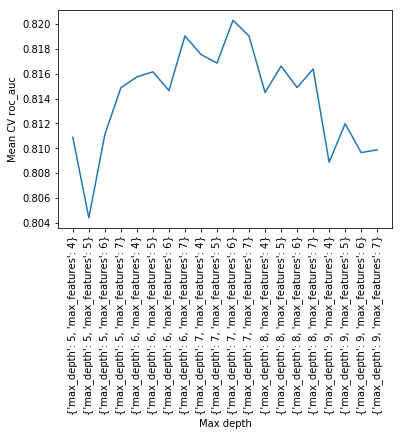

In [44]:
plt.plot(tree_grid.cv_results_['params'], 
         tree_grid.cv_results_['mean_test_score'])
plt.xlabel('Max depth')
plt.ylabel('Mean CV roc_auc')
plt.xticks(rotation='vertical');

In [57]:
tree_grid.grid_scores_

D:\ML\tools\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.81089, std: 0.00332, params: {'max_depth': 5, 'max_features': 4},
 mean: 0.80439, std: 0.00196, params: {'max_depth': 5, 'max_features': 5},
 mean: 0.81112, std: 0.00241, params: {'max_depth': 5, 'max_features': 6},
 mean: 0.81487, std: 0.00196, params: {'max_depth': 5, 'max_features': 7},
 mean: 0.81574, std: 0.00277, params: {'max_depth': 6, 'max_features': 4},
 mean: 0.81615, std: 0.00296, params: {'max_depth': 6, 'max_features': 5},
 mean: 0.81464, std: 0.00298, params: {'max_depth': 6, 'max_features': 6},
 mean: 0.81904, std: 0.00119, params: {'max_depth': 6, 'max_features': 7},
 mean: 0.81755, std: 0.00272, params: {'max_depth': 7, 'max_features': 4},
 mean: 0.81686, std: 0.00444, params: {'max_depth': 7, 'max_features': 5},
 mean: 0.82030, std: 0.00276, params: {'max_depth': 7, 'max_features': 6},
 mean: 0.81903, std: 0.00201, params: {'max_depth': 7, 'max_features': 7},
 mean: 0.81449, std: 0.00128, params: {'max_depth': 8, 'max_features': 4},
 mean: 0.81661, std: 0.00

In [63]:
from sklearn.metrics import roc_auc_score
for i, (train, test) in enumerate(skf.split(X, y)):
    tgp = tree_grid.predict(X.iloc[test])
    tg_acc = roc_auc_score(tgp,y.iloc[test])
    print (i, 'test  auc_roc:', tg_acc)
    tgp = tree_grid.predict(X.iloc[train])
    tg_acc = roc_auc_score(tgp,y.iloc[train])
    print (i, 'train auc_roc:', tg_acc)

0 test  auc_roc: 0.720086975819
0 train auc_roc: 0.718492108099
1 test  auc_roc: 0.722439629143
1 train auc_roc: 0.717937100703
2 test  auc_roc: 0.718581500603
2 train auc_roc: 0.718877350186
3 test  auc_roc: 0.721242741974
3 train auc_roc: 0.718204145705
4 test  auc_roc: 0.711887921195
4 train auc_roc: 0.720556195615


In [50]:
auc_vals = list()
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))
    tgp = tree_grid.predict(X.iloc[test])
    tg_acc = roc_auc_score(tgp,y.iloc[test])
    auc_vals.append(tg_acc)
    print ('test ', tg_acc)
    tgp = tree_grid.predict(X.iloc[train])
    tg_acc = roc_auc_score(tgp,y.iloc[train])
    print ('train', tg_acc)

[    0     2     3 ..., 45059 45060 45062] [    1     4    14 ..., 45043 45045 45061]
test  0.720086975819
train 0.718492108099
[    0     1     2 ..., 45060 45061 45062] [    6     9    15 ..., 45032 45035 45056]
test  0.722439629143
train 0.717937100703
[    1     2     3 ..., 45060 45061 45062] [    0    10    13 ..., 45054 45055 45058]
test  0.718581500603
train 0.718877350186
[    0     1     2 ..., 45058 45059 45061] [   12    24    26 ..., 45057 45060 45062]
test  0.721242741974
train 0.718204145705
[    0     1     4 ..., 45060 45061 45062] [    2     3     5 ..., 45048 45049 45059]
test  0.711887921195
train 0.720556195615


In [54]:
import statistics
statistics.stdev(auc_vals)

0.00414377149150839

In [49]:
tree_grid.best_estimator_.predict

<bound method BaseDecisionTree.predict of DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')>

In [29]:
tgp = tree_grid.predict(X)
tg_acc = roc_auc_score(tgp,y)
tg_acc

0.71881111543417653

In [69]:
%%time
cross_val_score(tree_grid, X, y, cv=skf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.4s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s


Wall time: 43.3 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


array([ 0.8192747 ,  0.8202384 ,  0.81738248,  0.81848931,  0.82035997])

# Простая реализация случайного леса

**<font color='red'>Задание 4.</font>**
Реализуйте свой собственный случайный лес с помощью `DecisionTreeClassifier` с лучшими параметрами из прошлого задания. В нашем лесу будет 10 деревьев, предсказанные вероятности которых вам нужно усреднить. 

Краткая спецификация: 
 - Используйте основу ниже
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Почему именно так – неважно, главное чтоб на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести
 - Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`
 - Также сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов 
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`
 - В методе `predict_proba` опять нужен цикл по всем деревьям. У тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- <b>0.833</b>
- 0.843
- 0.853

In [222]:
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=3, max_features=10, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        for i in range(0,self.n_estimators):
            np.random.seed(self.random_state+i)
            cols = list(X.sample(self.max_features, axis=1).columns)
            self.feat_ids_by_tree.append(cols)
            idxs = np.random.randint(0, len(X), len(X))
            dtc = DecisionTreeClassifier(random_state=self.random_state, 
                                         max_depth=self.max_depth,
                                         max_features=self.max_features,
                                         class_weight='balanced')
            dX = X.iloc[idxs][cols]
            dy = y.iloc[idxs]
            dtc.fit(dX, dy)
            self.trees.append(dtc)
        return self
        
    
    def predict_proba(self, X):
        predits = list()
        for i,tree in enumerate(self.trees):
            predits.append(tree.predict_proba(X[self.feat_ids_by_tree[i]]))
        
#         return np.around(np.mean(np.array(predits), axis=0))
        return np.mean(np.array(predits), axis=0)
#         return predits

In [223]:
# Ваш код здесь
rfcc = RandomForestClassifierCustom(max_depth=7, max_features=6)
rfcc.fit(X, y)

RandomForestClassifierCustom(max_depth=7, max_features=6, n_estimators=10,
               random_state=17)

In [236]:
%%time
cvs = cross_val_score(rfcc, X, y, cv=skf, scoring='roc_auc')

Wall time: 2.8 s


In [239]:
max(cvs)

0.83532829834931721

In [228]:
np.mean(_)

0.83143252828203984

**<font color='red'>Задание 5.</font>**
Тут сравним нашу собственную реализацию случайного леса с `sklearn`-овской. Для этого воспользуйтесь `RandomForestClassifier(n_jobs=1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Какое среднее значение ROC AUC на кросс-валидации мы в итоге получили? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- <b>0.833</b>
- 0.843
- 0.853

In [202]:
from sklearn.ensemble import RandomForestClassifier
# Ваш код здесь
rfc = RandomForestClassifier(n_jobs=1, random_state=17, max_depth=7, max_features=6)

In [203]:
%%time
cross_val_score(rfc, X, y, cv=skf, scoring='roc_auc')

Wall time: 1.8 s


array([ 0.83211645,  0.83219135,  0.82864841,  0.83301195,  0.82663044])

In [204]:
np.mean(_)

0.830519720262196

# Случайный лес `sklearn`, подбор гиперпараметров

**<font color='red'>Задание 6.</font>** 
В 3 задании мы находили оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. Давайте проверим это с помощью `GridSearchCV` `(RandomForestClassifier(random_state=17)`).  Только теперь расширим перебираемые значения `max_depth` до 15 включительно, так как в лесу нужны деревья поглубже (а почему именно – вы поняли из [статьи](https://habrahabr.ru/company/ods/blog/324402/)). Какими теперь стали лучшие значения гиперпараметров?

**<font color='red'>Варианты ответа:</font>**
- <b>`max_depth=8, max_features=4`</b>
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [229]:
max_depth_values = range(5, 16)
max_features_values = range(4, 8)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [230]:
# Ваш код здесь
rf = RandomForestClassifier(random_state=17)
forest_grid = GridSearchCV(rf, forest_params, cv=skf, n_jobs=-1, verbose=True, scoring='roc_auc')

In [231]:
forest_grid.fit(X,y)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   29.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 16), 'max_features': range(4, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [232]:
forest_grid.best_score_

0.83286806314143702

In [235]:
forest_grid.best_params_

{'max_depth': 8, 'max_features': 4}

In [234]:
forest_grid.grid_scores_

D:\ML\tools\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82390, std: 0.00304, params: {'max_depth': 5, 'max_features': 4},
 mean: 0.82351, std: 0.00164, params: {'max_depth': 5, 'max_features': 5},
 mean: 0.82218, std: 0.00320, params: {'max_depth': 5, 'max_features': 6},
 mean: 0.82076, std: 0.00346, params: {'max_depth': 5, 'max_features': 7},
 mean: 0.82803, std: 0.00292, params: {'max_depth': 6, 'max_features': 4},
 mean: 0.82834, std: 0.00178, params: {'max_depth': 6, 'max_features': 5},
 mean: 0.82767, std: 0.00294, params: {'max_depth': 6, 'max_features': 6},
 mean: 0.82694, std: 0.00237, params: {'max_depth': 6, 'max_features': 7},
 mean: 0.83112, std: 0.00268, params: {'max_depth': 7, 'max_features': 4},
 mean: 0.83141, std: 0.00217, params: {'max_depth': 7, 'max_features': 5},
 mean: 0.83052, std: 0.00246, params: {'max_depth': 7, 'max_features': 6},
 mean: 0.83034, std: 0.00231, params: {'max_depth': 7, 'max_features': 7},
 mean: 0.83287, std: 0.00242, params: {'max_depth': 8, 'max_features': 4},
 mean: 0.83263, std: 0.00

# Логистическая регрессия, подбор гиперпараметров

**<font color='red'>Задание 7.</font>**  Теперь сравним с логистической регрессией (укажем `class_weight='balanced'` и `random_state=17`). Сделайте полный перебор по параметру `C` из широкого диапазона значений `np.logspace(-8, 8, 17)`. 
Только сделаем это корректно и выстроим пайплайн – сначала масштабирование, затем обучение модели. 

Разберитесь с пайплайнами и проведите кросс-валидацию. Какое получилось лучшее значение средней ROC AUC? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.778
- <b>0.788</b>
- 0.798
- 0.808

In [240]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [245]:
# Ваш код здесь
logreg_grid = GridSearchCV(logit_pipe, logit_pipe_params, cv=skf, n_jobs=-1, scoring='roc_auc')

In [248]:
logreg_grid.fit(X, y);

In [249]:
print (logreg_grid.best_params_)
print (logreg_grid.best_score_)

{'logit__C': 100000.0}
0.787862675731


In [253]:
logreg_grid.predict(X)

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

# Логистическая регрессия и случайный лес на разреженных признаках

В случае небольшого числа признаков случайный лес показал себя лучше логистической регрессии. Однако один из главных недостатков деревьев проявляется при работе с разреженным данными, например с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Скачайте данные с отзывами к фильмам [отсюда](https://drive.google.com/open?id=12OPgwkx5Q63iqxXGR3MqZQpiMev_aB7g).

In [251]:
# Загрузим данные
df = pd.read_csv("../../data/movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [254]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# в Pipeline будем сразу преобразовать наш текст и обучать логистическую регрессию
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))])

**<font color='red'>Задание 8.</font>** Сделайте полный перебор по параметру `C` из выборки [0.1, 1, 10, 100]. Какое лучшее значение ROC AUC получилось на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- <b>0.85</b>

In [258]:
# Ваш код здесь
logit2_pipe_params = {'clf__C': [0.1, 1, 10, 100]}
logreg2_grid = GridSearchCV(classifier, logit2_pipe_params, cv=skf, n_jobs=-1, scoring='roc_auc')

In [259]:
%%time
logreg2_grid.fit(X_text, y_text)

Wall time: 1min 24s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...alty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [260]:
logreg2_grid.best_score_

0.85869278145215922

In [262]:
logreg2_grid.best_params_

{'clf__C': 1}

**<font color='red'>Задание 9.</font>** Теперь попробуем сравнить со случайным лесом. Аналогично делаем перебор и получаем максимальное ROC AUC. Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- <b>0.75</b>
- 0.84
- 0.85

In [271]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

rf_params = {'clf__min_samples_leaf': max_depth_values,
               'clf__max_features': max_features,
                'clf__max_depth': max_depth}

In [272]:
# Ваш код здесь
rf_grid = GridSearchCV(classifier, rf_params, cv=skf, n_jobs=-1, scoring='roc_auc')

In [273]:
%%time
rf_grid.fit(X_text,y_text)

Wall time: 34min 47s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...timators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__min_samples_leaf': range(5, 16), 'clf__max_features': [0.3, 0.5, 0.7], 'clf__max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [274]:
rf_grid.best_score_

0.74587829373243442